### Welcome to Deep Learning with PyTorch Series of project 

- Deep Learning with PyTorch : Build a Neural Network 
- **Deep Learning with PyTorch : Convolutional Neural Network**
- Deep Learning with PyTorch : Neural Style Transfer
- Many more coming

# Deep Learning with PyTorch : Build a Convolutional Neural Network

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

## Task 1 : Load CIFAR-10 Dataset

![](cifar-10.png)

PyTorch transforms : https://pytorch.org/docs/stable/torchvision/transforms.html
- **For CIFAR-10 Dataset Channel mean is 0.4914, 0.4822, 0.4465**
- **Channel wise Standard Deviation is 0.2470, 0.2435, 0.2616**

In [2]:
from torchvision import transforms as T, datasets

* ToTensor() : converts numpy or PIL images to tensor. It also converts your image dimension to C x H x W because in pytorch for network input channel should be first 

* Normalize() : Takes channel wise mean-list and channel wise standard deviation-list

In [3]:
data_transforms = T.Compose([
    T.ToTensor(), #H x W x C -> C x H x W
    T.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2470, 0.2435, 0.2616])
])

#### Parameters in datasets submodule

* data_path
* train : True (to load train set) or False (to load test set)
* download : True (to download) or False
* transform : to apply transformation on data


CIFAR-10 consists of 60,000 tiny 32 x 32 x 3(RGB) images, labeled with an interger corresponding to 1 of 10 : classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
train_ds = datasets.CIFAR10('cifar10/', train = True, download = True, transform = data_transforms)
test_ds = datasets.CIFAR10('cifar10/', train = False, download = True, transform = data_transforms)


Extracting cifar10/cifar-10-python.tar.gz to cifar10/
Files already downloaded and verified


In [5]:
print("Size of train set {}".format(len(train_ds)))
print("Size of test set {}".format(len(test_ds)))

Size of train set 50000
Size of test set 10000


## Task 2 : Plot examples from dataset

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'track']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


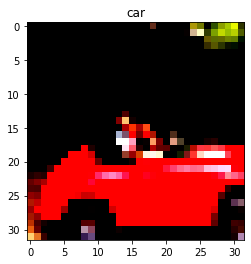

In [7]:
index = 99
image, label = train_ds[index]
#print(image.shape)
image = image.permute(1,2,0) #C(0) x H(1) x W(2)
#image = image * torch.Tensor([0.2470, 0.2435, 0.2616]) + torch.Tensor([0.4914, 0.4822, 0.4465]) #denormalizing to see the original image, multiplying & passing the channel wise SD and Mean values!
#print(image.shape)
plt.imshow(image)
plt.title(classes[label]);

## Task 3 : Load dataset into batches

In [8]:
from torch.utils.data import DataLoader, random_split

In [9]:
train_dataset, valid_dataset = random_split(train_ds, (45000, 5000))

In [10]:
trainloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validloader = DataLoader(valid_dataset, batch_size = 64, shuffle = True)
testloader  = DataLoader(test_ds, batch_size = 64, shuffle = True)

In [11]:
print("Total Batches created in Train Loader : {}".format(len(trainloader)))
print("Total Batches created in Train Loader : {}".format(len(validloader)))
print("Total Batches created in Train Loader : {}".format(len(testloader)))
print("Size of train dataset {}".format(len(trainloader.dataset)))
print("Size of train dataset {}".format(len(validloader.dataset)))
print("Size of train dataset {}".format(len(testloader.dataset)))

Total Batches created in Train Loader : 704
Total Batches created in Train Loader : 79
Total Batches created in Train Loader : 157
Size of train dataset 45000
Size of train dataset 5000
Size of train dataset 10000


In [12]:
dataiter = iter(trainloader)

images,labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


## Task 4 : Create Convolutional Neural Network 

In [13]:
from torch import nn
import torch.nn.functional as F


k : kernel_size or filters 
<br>
p : padding 
<br>
s : stride 
<br>
W : Width 
<br>
H : Height 

\begin{equation*}
For Same padding = \frac{k - 1}{2} \\
\end{equation*}

\begin{equation*}
W[next] = \frac{W[previous] + 2p - k}{s} + 1 \\
\end{equation*}

\begin{equation*}
H[next] = \frac{H[previous] + 2p - k}{s} + 1 \\
\end{equation*}

In [14]:
'''
3 x 32 x 32 (input)

       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1
       V activation = relu 
       
16 x 32 x 32

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
16 x 15 x 15

       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2
       V activation = relu
       
32 x 15 x 15 

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
32 x 8 x 8

       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3
       V activation = relu 
       
64 x 8 x 8

       | k = (2,2), s = 2 , operation = MaxPooling #maxpool
       V

64 x 4 x  4
    
       |  operation = Flatten
       V
500

       |  linear,activation = relu #linear1
       V

128
       |  linear,activation = relu #linear2
       V

10  linear, activation = log_softmax #linear3
'''

'\n3 x 32 x 32 (input)\n\n       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1\n       V activation = relu \n       \n16 x 32 x 32\n\n       | k = (2,2), s = 2, operation = Max Pooling #maxpool\n       V \n       \n16 x 15 x 15\n\n       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2\n       V activation = relu\n       \n32 x 15 x 15 \n\n       | k = (2,2), s = 2, operation = Max Pooling #maxpool\n       V \n       \n32 x 8 x 8\n\n       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3\n       V activation = relu \n       \n64 x 8 x 8\n\n       | k = (2,2), s = 2 , operation = MaxPooling #maxpool\n       V\n\n64 x 4 x  4\n    \n       |  operation = Flatten\n       V\n500\n\n       |  linear,activation = relu #linear1\n       V\n\n128\n       |  linear,activation = relu #linear2\n       V\n\n10  linear, activation = log_softmax #linear3\n'

In [15]:
class MyModel(nn.Module):

  def __init__(self):
    super(MyModel,self).__init__()

    self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1, stride=1)
    self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1, stride=1)
    self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, stride=1)
    self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)

    self.linear_1 = nn.Linear(in_features=1024, out_features=500)
    self.linear_2 = nn.Linear(in_features=500, out_features=128)
    self.linear_3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, images):
    #images : 3 x 32 x 32
    a1 = self.maxpool(F.relu(self.conv_1(images)))
    a2 = self.maxpool(F.relu(self.conv_2(a1)))
    a3 = self.maxpool(F.relu(self.conv_3(a2)))
    a3 = a3.view(a3.shape[0],-1) #(bs,64*4*4) -> (bs,64*4*4 -> (bs,1024)) #flatten
    a4 = F.relu(self.linear_1(a3))
    a5 = F.relu(self.linear_2(a4))
    a6 = F.log_softmax(self.linear_3(a5), dim=1)

    return a6

In [16]:
model = MyModel()
model

MyModel(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=500, bias=True)
  (linear_2): Linear(in_features=500, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
from torchsummary import summary

In [18]:
summary(model, input_size= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 500]         512,500
            Linear-8                  [-1, 128]          64,128
            Linear-9                   [-1, 10]           1,290
Total params: 601,502
Trainable params: 601,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.29
Estimated Total Size (MB): 2.58
-------------------------------------------

## Task 5 : Training loop

In [21]:
from torch import optim
from utils import multiclass_accuracy
from tqdm import tqdm

criterion = nn.NLLLoss() #(logps,true_labels)
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs = 10

In [ ]:
for i in range(epochs):
  train_loss = 0.0
  train_acc = 0.0
  valid_loss = 0.0
  valid_acc = 0.0

  model.train()
  
  for images, labels in tqdm(trainloader):
    
    logps = model(images) #output ps
    
    loss = criterion(logps,labels)
    
    optimizer.zero_grad()
    loss.backward() #dw,db
    optimizer.step() #w = w-lr*dw, b = b-lr*db #updating the values of weights and biases

    train_loss += loss.item()
    ps = torch.exp(logps) #log_softmax -> softmax #removing log from log prob to get the softmax probabilities
    train_acc += multiclass_accuracy(ps,labels)
  
  model.eval() #make sures to switch off the dropout, batch norm

  for images, labels in tqdm(validloader):

    logps = model(images)
    loss = criterion(logps, labels)

    valid_loss += loss.item() #adding all the batch loss
    ps = torch.exp(logps)
    valid_acc += multiclass_accuracy(ps, labels) #ps = probabilities

    #avging all trainloss, validloss and accuracies
    avg_train_loss = train_loss/len(trainloader)
    avg_valid_loss = valid_loss/len(trainloader)
    avg_train_acc = train_acc/len(trainloader)
    avg_valid_acc = valid_acc/len(trainloader)

    print("Epoch: {} Train Loss : {:.4f} Train Acc : {:.4f}".format(i,avg_train_loss, avg_train_acc))
    print("Epoch: {} Valid Loss : {:.4f} Valid Acc : {:.4f}".format(i,avg_valid_loss, avg_valid_acc))

## Task 6 : Evaluate model 

In [23]:
from utils import view_classify

In [24]:
test_loss = 0.0
test_acc= 0.0

model.eval() #dropout, batchnorm

for images, labels in tqdm(testloader):

    logps = model(images)
    loss = criterion(logps, labels)
    test_loss += loss.item() #adding all the batch loss
    ps = torch.exp(logps)
    test_acc += multiclass_accuracy(ps, labels)

avg_test_loss = test_loss/len(testloader)
avg_test_acc  = test_acc/len(testloader)
print("Test Loss : {:.4f} Test Acc : {:.4f}".format(avg_test_loss, avg_test_acc))

100%|██████████| 157/157 [00:06<00:00, 25.86it/s]

Test Loss : 1.0923 Test Acc : 0.6949


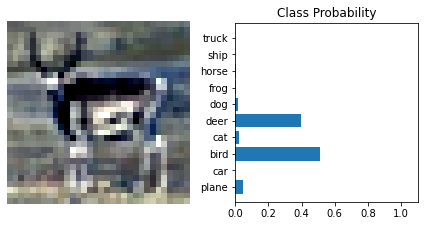

In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()

index = 30
logps = model(images[index].unsqueeze(0))
ps = torch.exp(logps)

view_classify(images[index],ps)